In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

import seaborn as sns

from datetime import datetime
import os

dp = os.environ.get('pub_data')

## 0. Example

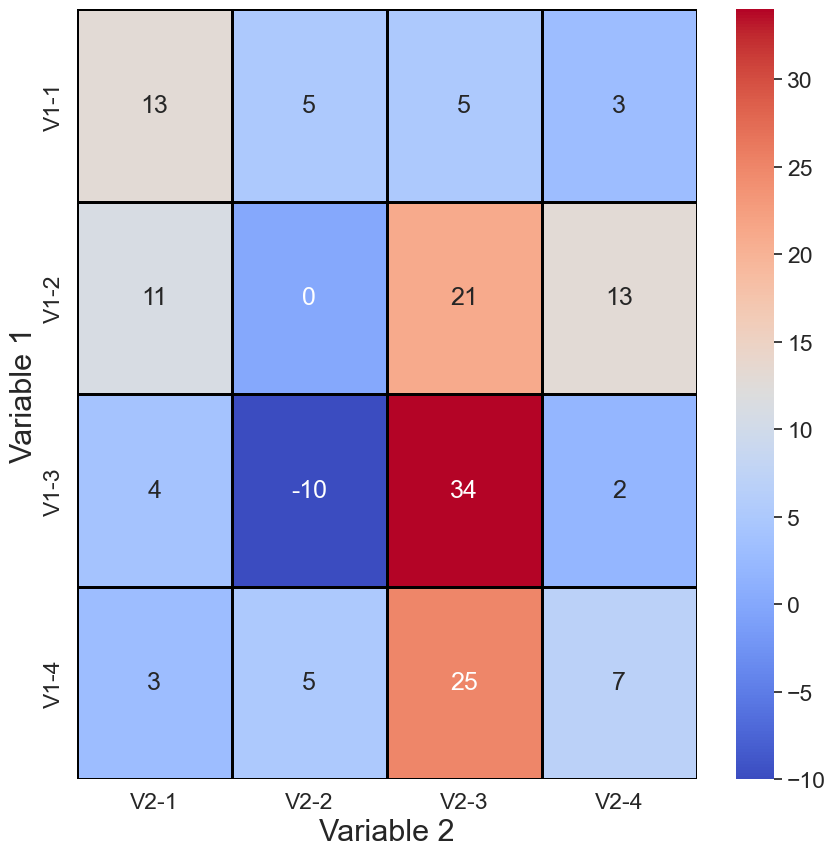

In [65]:
# Hard code matrix
conf_matrix = [[13,5,5,3],[11,0,21,13],[4,-10,34,2],[3,5,25,7]]

# Create pandas dataframe with matrix
V1 = ['V1-1', 'V1-2', 'V1-3', 'V1-4']
V2 = ['V2-1', 'V2-2', 'V2-3', 'V2-4']
conf_matrix_df = pd.DataFrame(conf_matrix, columns=V2, index=V1)

# Plot example heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df, cmap='coolwarm', annot=True, fmt='.5g', linewidths=2, linecolor='black')
plt.xlabel('Variable 2', fontsize=22)
plt.ylabel('Variable 1', fontsize=22)

plt.savefig('../figures/example.png', format='png', dpi=150)


## 1. Confusion Matrix

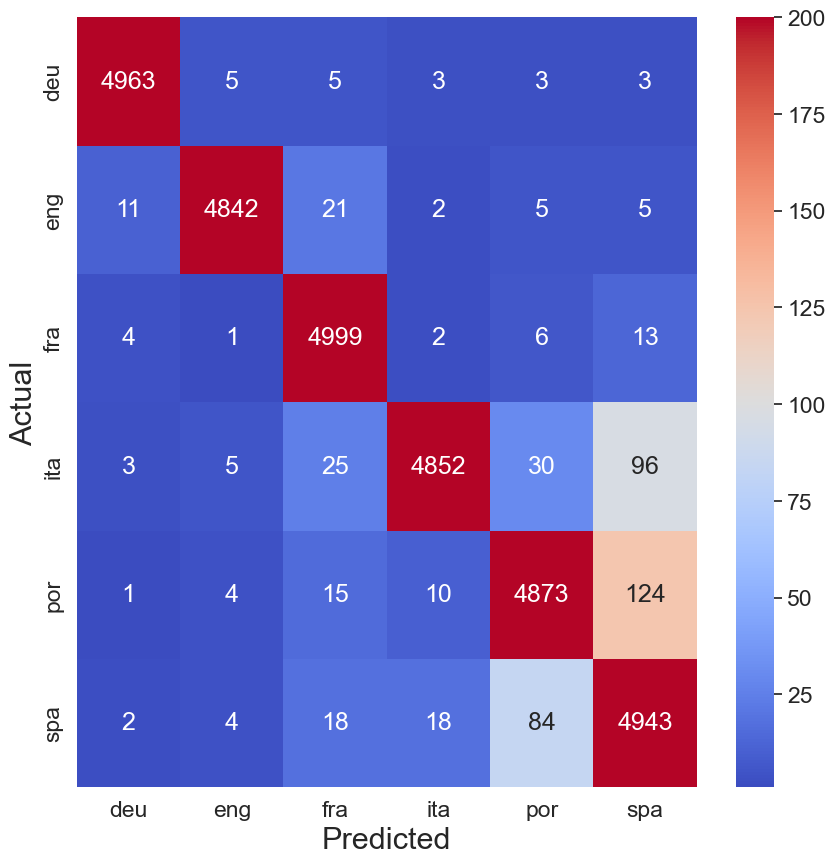

In [66]:
# Hard code confusion matrix
conf_matrix = [[4963, 5, 5, 3, 3, 3], [11, 4842, 21, 2, 5, 5], [4, 1, 4999, 2, 6, 13], [3, 5, 25, 4852, 30, 96], [1, 4, 15, 10, 4873, 124], [2, 4, 18, 18, 84, 4943]]

# Create pandas dataframe with confusion matrix
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
conf_matrix_df = pd.DataFrame(conf_matrix, columns=lang, index=lang)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)

sns.heatmap(conf_matrix_df, cmap='coolwarm', annot=True, fmt='.5g', vmax=200)

plt.xlabel('Predicted', fontsize=22)
plt.ylabel('Actual', fontsize=22)

plt.savefig('../figures/confusion_matrix.png', format='png', dpi=150)

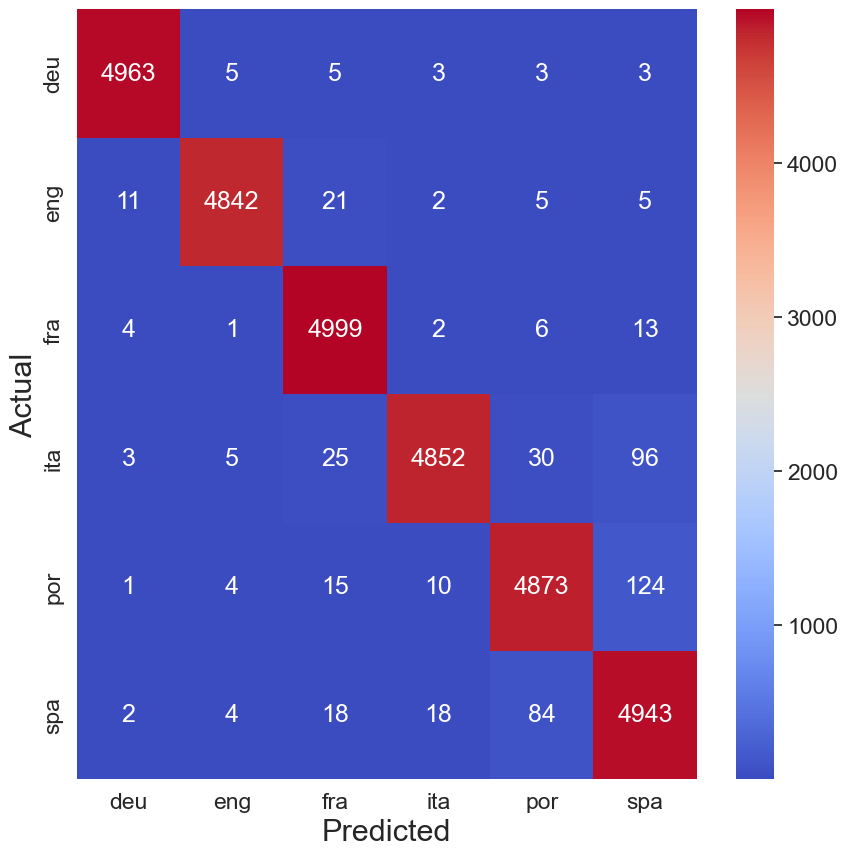

In [67]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)

sns.heatmap(conf_matrix_df, cmap='coolwarm', annot=True, fmt='.5g')

plt.xlabel('Predicted', fontsize=22)
plt.ylabel('Actual', fontsize=22)

plt.savefig('../figures/confusion_matrix_nomax.png', format='png', dpi=150)

## 2. Movement between groups

In [68]:
# Load dataset
df = pd.read_csv(dp + 'pollution_us_2000_2016.csv', index_col=0)

# Create column with year of reading
date = [datetime.strptime(dt, '%Y-%m-%d') for dt in df['Date Local']]
df['year'] = [dt.year for dt in date]
df.columns

Index(['State Code', 'County Code', 'Site Num', 'Address', 'State', 'County',
       'City', 'Date Local', 'NO2 Units', 'NO2 Mean', 'NO2 1st Max Value',
       'NO2 1st Max Hour', 'NO2 AQI', 'O3 Units', 'O3 Mean',
       'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI',
       'CO Units', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI',
       'year'],
      dtype='object')

In [69]:
def aqiGroup(api):
    '''Return group name based on AQI values'''
    if api <= 50:
        return 'Good'
    elif api <= 100:
        return 'Moderate'
    elif api <= 150:
        return 'Unhealthy \n(Sensitive Groups)'
    elif api <= 200:
        return 'Unhealthy'
    elif api <= 300:
        return 'Very Unhealthy'
    elif api <= 500:
        return 'Hazardous'

In [70]:
# Get maximum O3 AQI AQI for each city each year
df_max = df.groupby(['City', 'year'], as_index=False)['O3 AQI'].max()

# Get AQI group of maximum AQI value
df_max['AQI Group'] = [aqiGroup(aqi) for aqi in df_max['O3 AQI']]

# AQI groups in 2016
AQI_2016 = df_max[df_max.year==2016][['City', 'AQI Group']]
AQI_2016.columns = ['City', 'AQI 2016']

# AQI groups in 2010
AQI_2010 = df_max[df_max.year==2010][['City', 'AQI Group']]
AQI_2010.columns = ['City', 'AQI 2010']

# Join tables and replace missing values
AQI = AQI_2016.join(AQI_2010.set_index(['City']), how='outer', on=['City'])
AQI.fillna('Not operational', inplace=True)

AQI

,City,AQI 2016,AQI 2010
42.0,Arden-Arcade,Good,Unhealthy \n(Sensitive Groups)
69.0,Baton Rouge,Moderate,Unhealthy \n(Sensitive Groups)
85.0,Beltsville,Moderate,Not operational
108.0,Bethel Island,Moderate,Unhealthy \n(Sensitive Groups)
112.0,Birmingham,Unhealthy \n(Sensitive Groups),Not operational
...,...,...,...
NaN,San Antonio,Not operational,Moderate
NaN,San Diego,Not operational,Moderate
NaN,Scottsdale,Not operational,Moderate
NaN,Tijuana,Not operational,Good


In [71]:
# NOTE: 'Very Unhealthy' and 'Hazardous' groups have been exluded
groups = ['Good', 'Moderate', 'Unhealthy \n(Sensitive Groups)', 'Unhealthy', 'Not operational']

# Create matrix of group counts
hm_array = []
for i in groups:
    hm_array_i = []
    for j in groups:
        df = AQI[(AQI['AQI 2010'] == i)&(AQI['AQI 2016']==j)]
        hm_array_i.append(len(df))
    hm_array.append(hm_array_i)

# Create dataframe from matrix
hm_df = pd.DataFrame(hm_array, columns=groups, index=groups)

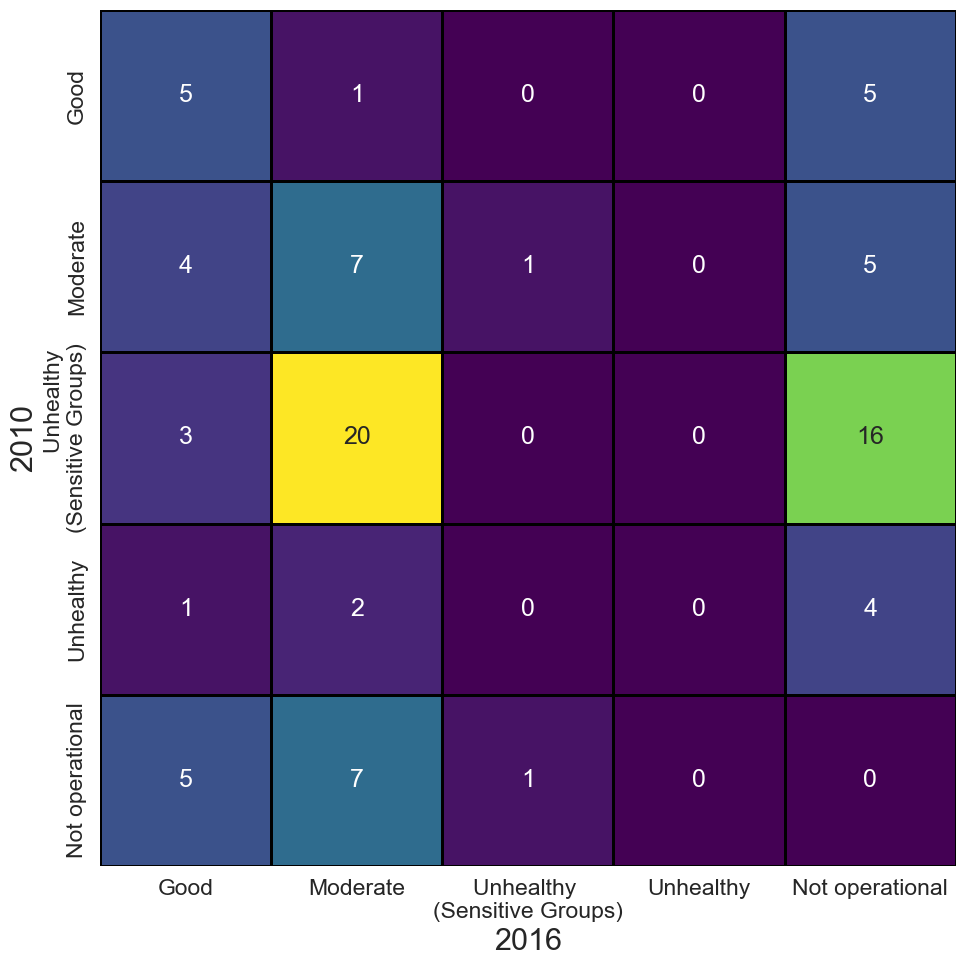

In [72]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(hm_df, cmap='viridis', annot=True, fmt='.5g', cbar=False, linewidths=2, linecolor='black')

plt.xlabel('2016', fontsize=22)
plt.ylabel('2010', fontsize=22)

plt.tight_layout()
plt.savefig('../figures/group_movements.png', format='png', dpi=150)

## 3. Temprature changes through time

In [73]:
df = pd.read_csv(dp + 'Global_Temp_Monthly.csv')

# Only use GISTEMP record
df = df[df.Source == 'GISTEMP']

# Get year and month of record
date = [datetime.strptime(dt, '%Y-%m') for dt in df['Date']]
df['year'] = [dt.year for dt in date]
df['month'] = [dt.month for dt in date]

df.head()

,Source,Date,Mean,year,month
1,GISTEMP,2016-12,0.81,2016,12
3,GISTEMP,2016-11,0.93,2016,11
5,GISTEMP,2016-10,0.89,2016,10
7,GISTEMP,2016-09,0.87,2016,9
9,GISTEMP,2016-08,0.98,2016,8


In [74]:
years = range(1900,2017)
months = range(1,13)

# Create matrix of temprature values
hm_array = []
for m in months:
    hm_array_y = []
    for y in years:
        mean =  df[(df.year == y) & (df.month == m)]['Mean'] 
        mean = mean.to_numpy()[0]
        hm_array_y.append(mean)  
    hm_array.append(hm_array_y)
    
# Create dataframe from matrix
hm_df = pd.DataFrame(hm_array,columns=years,index=months)
hm_df


,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,-0.40,-0.30,-0.19,-0.27,-0.64,-0.38,-0.31,-0.44,-0.46,-0.70,...,0.96,0.24,0.62,0.73,0.51,0.46,0.68,0.73,0.81,1.17
2,-0.08,-0.05,-0.03,-0.06,-0.55,-0.59,-0.34,-0.53,-0.36,-0.47,...,0.70,0.36,0.53,0.78,0.53,0.49,0.55,0.51,0.86,1.35
3,0.02,0.05,-0.29,-0.23,-0.46,-0.25,-0.15,-0.25,-0.58,-0.52,...,0.70,0.73,0.53,0.92,0.64,0.58,0.66,0.77,0.90,1.30
4,-0.14,-0.06,-0.27,-0.39,-0.50,-0.36,-0.02,-0.40,-0.46,-0.59,...,0.76,0.53,0.61,0.87,0.65,0.69,0.52,0.78,0.74,1.09
5,-0.06,-0.18,-0.31,-0.41,-0.50,-0.33,-0.21,-0.46,-0.40,-0.54,...,0.67,0.51,0.65,0.75,0.53,0.76,0.61,0.87,0.78,0.93
6,-0.15,-0.10,-0.34,-0.44,-0.49,-0.31,-0.22,-0.43,-0.39,-0.52,...,0.58,0.48,0.65,0.64,0.59,0.62,0.65,0.66,0.78,0.76
7,-0.09,-0.09,-0.26,-0.30,-0.48,-0.25,-0.27,-0.35,-0.35,-0.43,...,0.62,0.60,0.72,0.62,0.73,0.57,0.59,0.57,0.71,0.83
8,-0.04,-0.13,-0.28,-0.44,-0.43,-0.21,-0.19,-0.37,-0.45,-0.30,...,0.60,0.44,0.66,0.65,0.73,0.63,0.66,0.82,0.78,0.98
9,0.01,-0.17,-0.20,-0.43,-0.47,-0.15,-0.25,-0.32,-0.33,-0.37,...,0.64,0.65,0.70,0.61,0.56,0.76,0.78,0.90,0.81,0.87
10,0.08,-0.29,-0.27,-0.42,-0.35,-0.23,-0.20,-0.24,-0.43,-0.39,...,0.60,0.67,0.64,0.71,0.66,0.78,0.69,0.85,1.06,0.89


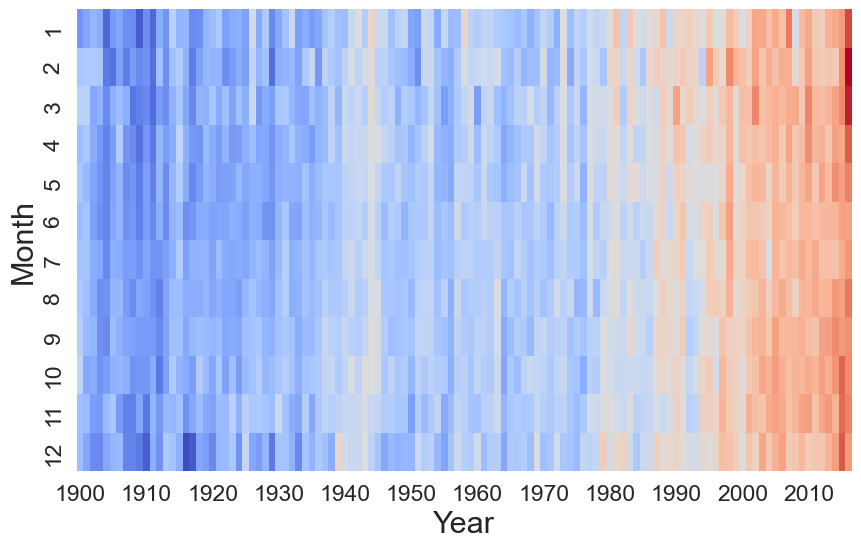

In [75]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(hm_df,
            cmap='coolwarm',
            cbar=False,
            xticklabels=10)

plt.xlabel('Year',fontsize=22)
plt.ylabel('Month',fontsize=22)

plt.savefig('../figures/temprature.png', format='png', dpi=150)
plt.savefig('../figures/temprature_cover.png', format='png', dpi=300)

## SHAP correlation matrix

In [76]:
# Load dataset
df = pd.read_csv(dp + 'Real_estate_valuation_data_set.csv',index_col=0)

# Create correlation matrix
corr_matrix = df.corr()

In [77]:
# Define mask used to cover squares above diagonal 
mask = []
for i in range(len(corr_matrix.columns)):
    mask_i = []
    for j in range(len(corr_matrix.columns)):
        if i<j:
            mask_i.append(True)
        else: 
            mask_i.append(False)
    mask.append(mask_i)

mask = np.array(mask)

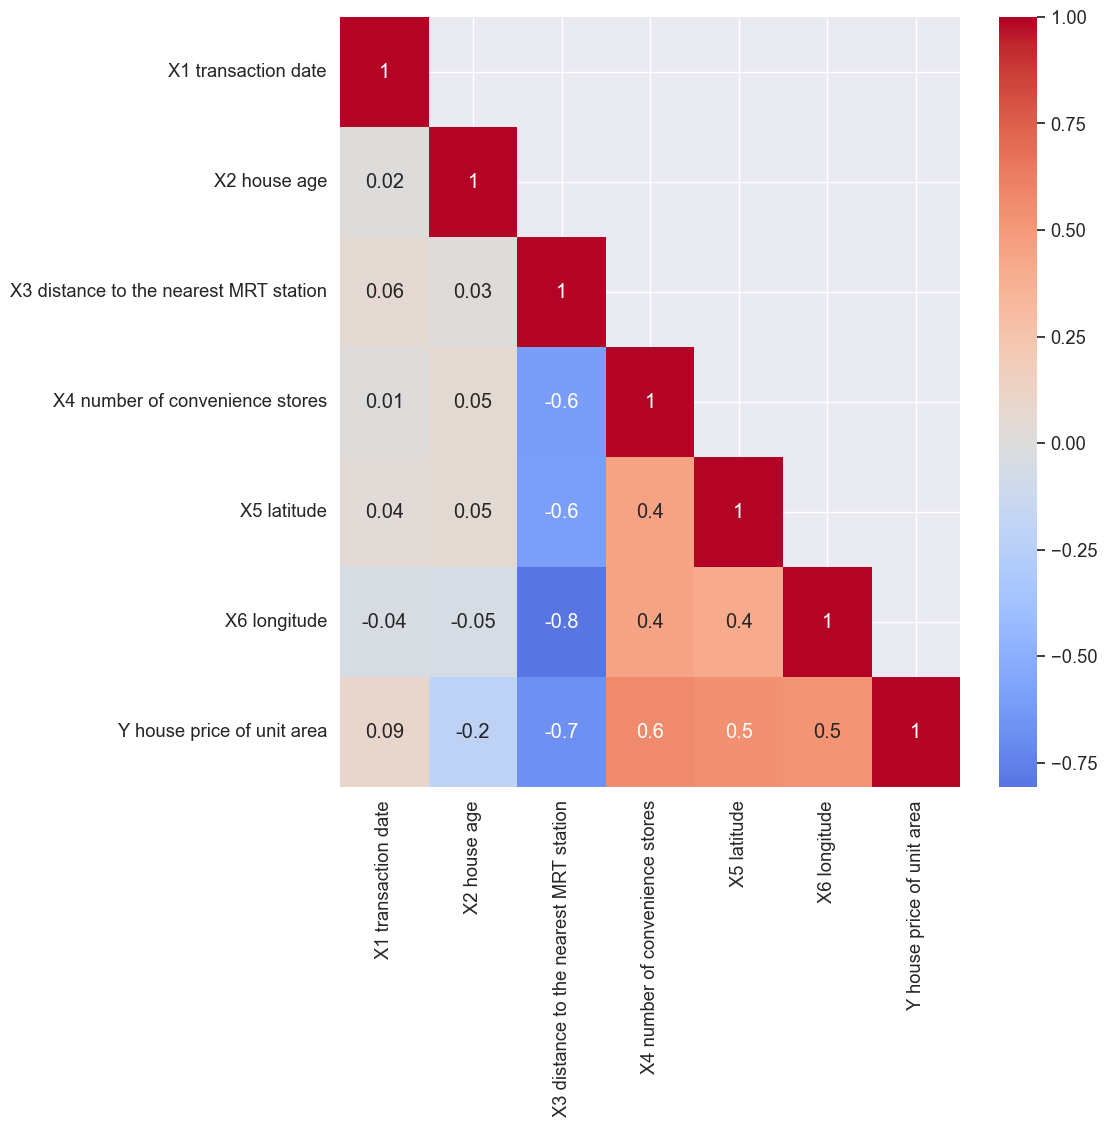

In [78]:
# Display Correlations
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix,cmap='coolwarm', center=0,annot=True, fmt='.1g', mask=mask)
# sns.heatmap(corr_matrix,cmap='coolwarm', center=0,annot=True, fmt='.1g')

plt.savefig('../figures/correlation.png', dpi=200,bbox_inches='tight')